In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, next_states, rewards, dones, rates

In [4]:
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        actions_logits = tf.layers.dense(inputs=nl2, units=action_size)
        return actions_logits

In [5]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Hidden layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        Qs_logits = tf.layers.dense(inputs=nl2, units=1)
        return Qs_logits

In [6]:
def model_loss(state_size, action_size, hidden_size, 
               states, actions, next_states, rewards, dones, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    gloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    dQs = discriminator(states=states, actions=actions_labels, action_size=action_size, hidden_size=hidden_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                   labels=rates)) # [0, 1]
    next_actions_logits = generator(states=next_states, hidden_size=hidden_size, action_size=action_size, 
                                    reuse=True)
    nextQs_logits = discriminator(states=next_states, actions=next_actions_logits, action_size=action_size, 
                                  hidden_size=hidden_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1])
    targetQs = rewards + (0.99 * nextQs * (1-dones))
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    glossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs,
                                                                    labels=tf.nn.sigmoid(targetQs))) # [0, 1]
    return actions_logits, gloss, dloss, glossQ

In [7]:
def model_opt(g_loss, d_loss, g_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optQ = tf.train.AdamOptimizer(g_learning_rate).minimize(g_lossQ, var_list=g_vars)
    return g_opt, d_opt, g_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.g_loss, self.d_loss, self.g_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size, # model init parameters
            states=self.states, actions=self.actions, next_states=self.next_states, rewards=self.rewards, 
            dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.g_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss,
                                                        g_lossQ=self.g_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500 # [0, 1]
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # [0, 1]
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1:
                        memory.buffer[-1-idx][-1] = rate
                        
            # Training with the maxrated minibatch
            while True:
                batch = memory.buffer
                percentage = 0.9
                #for idx in range(memory_size// batch_size):
                idx_arr = np.arange(memory_size// batch_size)
                idx = np.random.choice(idx_arr)
                rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
                if np.max(rates) > 0:
                    break
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            gloss, _, dloss, _ = sess.run([model.g_loss, model.g_opt, model.d_loss, model.d_opt], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            glossQ, _ = sess.run([model.g_lossQ, model.g_optQ], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones, 
                                                       model.rates: rates})
            dloss_batch.append(dloss)
            gloss_batch.append(gloss)
            glossQ_batch.append(glossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 gloss:0.7118 dloss:0.6067 glossQ:0.7653 exploreP:0.9982
Episode:1 meanR:22.0000 R:26.0000 rate:0.0520 gloss:0.7049 dloss:0.5915 glossQ:0.7762 exploreP:0.9957
Episode:2 meanR:23.3333 R:26.0000 rate:0.0520 gloss:0.7065 dloss:0.5921 glossQ:0.7762 exploreP:0.9931
Episode:3 meanR:21.0000 R:14.0000 rate:0.0280 gloss:0.7006 dloss:0.5709 glossQ:0.7948 exploreP:0.9917
Episode:4 meanR:24.6000 R:39.0000 rate:0.0780 gloss:0.7019 dloss:0.5725 glossQ:0.7914 exploreP:0.9879
Episode:5 meanR:23.5000 R:18.0000 rate:0.0360 gloss:0.7001 dloss:0.5639 glossQ:0.7991 exploreP:0.9861
Episode:6 meanR:22.4286 R:16.0000 rate:0.0320 gloss:0.6977 dloss:0.5514 glossQ:0.8096 exploreP:0.9846
Episode:7 meanR:23.3750 R:30.0000 rate:0.0600 gloss:0.7032 dloss:0.5613 glossQ:0.8056 exploreP:0.9817
Episode:8 meanR:23.5556 R:25.0000 rate:0.0500 gloss:0.6952 dloss:0.5454 glossQ:0.8158 exploreP:0.9792
Episode:9 meanR:23.9000 R:27.0000 rate:0.0540 gloss:0.7000 dloss:0.5411 glossQ:0.8

Episode:80 meanR:23.5185 R:19.0000 rate:0.0380 gloss:0.6756 dloss:0.3778 glossQ:0.2120 exploreP:0.8283
Episode:81 meanR:24.0854 R:70.0000 rate:0.1400 gloss:0.6905 dloss:0.3762 glossQ:0.2096 exploreP:0.8226
Episode:82 meanR:24.0120 R:18.0000 rate:0.0360 gloss:0.6895 dloss:0.3969 glossQ:0.2136 exploreP:0.8211
Episode:83 meanR:24.1548 R:36.0000 rate:0.0720 gloss:0.6761 dloss:0.3830 glossQ:0.2028 exploreP:0.8182
Episode:84 meanR:24.1529 R:24.0000 rate:0.0480 gloss:0.6805 dloss:0.3911 glossQ:0.2053 exploreP:0.8163
Episode:85 meanR:24.0930 R:19.0000 rate:0.0380 gloss:0.6767 dloss:0.3616 glossQ:0.1981 exploreP:0.8147
Episode:86 meanR:24.0115 R:17.0000 rate:0.0340 gloss:0.6812 dloss:0.3847 glossQ:0.1965 exploreP:0.8134
Episode:87 meanR:23.9205 R:16.0000 rate:0.0320 gloss:0.6758 dloss:0.3894 glossQ:0.1858 exploreP:0.8121
Episode:88 meanR:24.0000 R:31.0000 rate:0.0620 gloss:0.6796 dloss:0.3831 glossQ:0.1935 exploreP:0.8096
Episode:89 meanR:24.1444 R:37.0000 rate:0.0740 gloss:0.6826 dloss:0.3921 

Episode:159 meanR:46.2000 R:226.0000 rate:0.4520 gloss:0.6732 dloss:0.3884 glossQ:0.1686 exploreP:0.5576
Episode:160 meanR:47.0100 R:96.0000 rate:0.1920 gloss:0.6659 dloss:0.3766 glossQ:0.1705 exploreP:0.5523
Episode:161 meanR:47.8300 R:106.0000 rate:0.2120 gloss:0.6732 dloss:0.3841 glossQ:0.1619 exploreP:0.5466
Episode:162 meanR:48.7000 R:109.0000 rate:0.2180 gloss:0.6689 dloss:0.3896 glossQ:0.1620 exploreP:0.5408
Episode:163 meanR:49.2300 R:78.0000 rate:0.1560 gloss:0.6795 dloss:0.3946 glossQ:0.1759 exploreP:0.5367
Episode:164 meanR:48.9700 R:30.0000 rate:0.0600 gloss:0.6654 dloss:0.4339 glossQ:0.1599 exploreP:0.5351
Episode:165 meanR:49.8300 R:105.0000 rate:0.2100 gloss:0.6729 dloss:0.4101 glossQ:0.1687 exploreP:0.5296
Episode:166 meanR:50.5100 R:89.0000 rate:0.1780 gloss:0.6715 dloss:0.3984 glossQ:0.1694 exploreP:0.5250
Episode:167 meanR:50.8400 R:66.0000 rate:0.1320 gloss:0.6735 dloss:0.3964 glossQ:0.1694 exploreP:0.5216
Episode:168 meanR:52.0300 R:164.0000 rate:0.3280 gloss:0.672

Episode:238 meanR:125.8100 R:170.0000 rate:0.3400 gloss:0.6670 dloss:0.4614 glossQ:0.1977 exploreP:0.1942
Episode:239 meanR:126.8700 R:126.0000 rate:0.2520 gloss:0.6692 dloss:0.4371 glossQ:0.2009 exploreP:0.1919
Episode:240 meanR:129.6000 R:307.0000 rate:0.6140 gloss:0.6637 dloss:0.4610 glossQ:0.2078 exploreP:0.1864
Episode:241 meanR:130.8300 R:177.0000 rate:0.3540 gloss:0.6646 dloss:0.4362 glossQ:0.2047 exploreP:0.1833
Episode:242 meanR:132.7000 R:233.0000 rate:0.4660 gloss:0.6658 dloss:0.4599 glossQ:0.2065 exploreP:0.1793
Episode:243 meanR:133.5500 R:148.0000 rate:0.2960 gloss:0.6693 dloss:0.4604 glossQ:0.2083 exploreP:0.1769
Episode:244 meanR:134.4800 R:166.0000 rate:0.3320 gloss:0.6627 dloss:0.4648 glossQ:0.2170 exploreP:0.1741
Episode:245 meanR:135.9500 R:248.0000 rate:0.4960 gloss:0.6621 dloss:0.4700 glossQ:0.2218 exploreP:0.1701
Episode:246 meanR:137.0100 R:175.0000 rate:0.3500 gloss:0.6658 dloss:0.4669 glossQ:0.2233 exploreP:0.1673
Episode:247 meanR:138.7900 R:281.0000 rate:0.5

Episode:316 meanR:220.7700 R:276.0000 rate:0.5520 gloss:0.6479 dloss:0.6012 glossQ:0.3310 exploreP:0.0404
Episode:317 meanR:219.4200 R:141.0000 rate:0.2820 gloss:0.6507 dloss:0.5873 glossQ:0.3535 exploreP:0.0400
Episode:318 meanR:218.8500 R:178.0000 rate:0.3560 gloss:0.6484 dloss:0.5640 glossQ:0.3639 exploreP:0.0395
Episode:319 meanR:218.9800 R:182.0000 rate:0.3640 gloss:0.6537 dloss:0.5613 glossQ:0.3602 exploreP:0.0390
Episode:320 meanR:219.7800 R:204.0000 rate:0.4080 gloss:0.6495 dloss:0.5653 glossQ:0.3315 exploreP:0.0384
Episode:321 meanR:221.8000 R:310.0000 rate:0.6200 gloss:0.6514 dloss:0.5898 glossQ:0.3316 exploreP:0.0375
Episode:322 meanR:224.2100 R:365.0000 rate:0.7300 gloss:0.6469 dloss:0.5843 glossQ:0.3524 exploreP:0.0365
Episode:323 meanR:223.8400 R:151.0000 rate:0.3020 gloss:0.6538 dloss:0.5749 glossQ:0.3615 exploreP:0.0361
Episode:324 meanR:223.9900 R:167.0000 rate:0.3340 gloss:0.6475 dloss:0.5958 glossQ:0.3323 exploreP:0.0357
Episode:325 meanR:225.6000 R:342.0000 rate:0.6

Episode:394 meanR:220.8800 R:134.0000 rate:0.2680 gloss:0.6024 dloss:0.6750 glossQ:0.4770 exploreP:0.0158
Episode:395 meanR:223.3400 R:438.0000 rate:0.8760 gloss:0.6154 dloss:0.6516 glossQ:0.4632 exploreP:0.0155
Episode:396 meanR:226.4100 R:500.0000 rate:1.0000 gloss:0.6080 dloss:0.6594 glossQ:0.4948 exploreP:0.0153
Episode:397 meanR:226.0500 R:235.0000 rate:0.4700 gloss:0.6058 dloss:0.6570 glossQ:0.4717 exploreP:0.0151
Episode:398 meanR:228.4300 R:500.0000 rate:1.0000 gloss:0.6100 dloss:0.6623 glossQ:0.4881 exploreP:0.0149
Episode:399 meanR:229.1800 R:212.0000 rate:0.4240 gloss:0.6202 dloss:0.6406 glossQ:0.4898 exploreP:0.0148
Episode:400 meanR:230.2100 R:270.0000 rate:0.5400 gloss:0.6097 dloss:0.6525 glossQ:0.4630 exploreP:0.0147
Episode:401 meanR:228.9300 R:178.0000 rate:0.3560 gloss:0.6089 dloss:0.6441 glossQ:0.4590 exploreP:0.0146
Episode:402 meanR:230.1100 R:318.0000 rate:0.6360 gloss:0.6103 dloss:0.6471 glossQ:0.4756 exploreP:0.0144
Episode:403 meanR:232.3300 R:500.0000 rate:1.0

Episode:472 meanR:273.8000 R:38.0000 rate:0.0760 gloss:0.6448 dloss:0.6756 glossQ:0.6141 exploreP:0.0106
Episode:473 meanR:272.2500 R:35.0000 rate:0.0700 gloss:0.6401 dloss:0.6544 glossQ:0.5909 exploreP:0.0106
Episode:474 meanR:272.0500 R:85.0000 rate:0.1700 gloss:0.6758 dloss:0.6942 glossQ:0.5955 exploreP:0.0106
Episode:475 meanR:271.8600 R:100.0000 rate:0.2000 gloss:0.6857 dloss:0.6846 glossQ:0.5954 exploreP:0.0106
Episode:476 meanR:270.1200 R:58.0000 rate:0.1160 gloss:0.6686 dloss:0.6965 glossQ:0.6089 exploreP:0.0106
Episode:477 meanR:269.4900 R:98.0000 rate:0.1960 gloss:0.6665 dloss:0.6903 glossQ:0.6099 exploreP:0.0106
Episode:478 meanR:267.8700 R:30.0000 rate:0.0600 gloss:0.6841 dloss:0.6926 glossQ:0.6108 exploreP:0.0106
Episode:479 meanR:266.0800 R:59.0000 rate:0.1180 gloss:0.6411 dloss:0.6899 glossQ:0.6266 exploreP:0.0106
Episode:480 meanR:264.1800 R:42.0000 rate:0.0840 gloss:0.6452 dloss:0.6769 glossQ:0.6212 exploreP:0.0106
Episode:481 meanR:259.8600 R:68.0000 rate:0.1360 gloss

Episode:550 meanR:111.4400 R:141.0000 rate:0.2820 gloss:0.5797 dloss:0.6958 glossQ:0.5884 exploreP:0.0103
Episode:551 meanR:108.0800 R:164.0000 rate:0.3280 gloss:0.5759 dloss:0.6802 glossQ:0.5938 exploreP:0.0103
Episode:552 meanR:104.5200 R:144.0000 rate:0.2880 gloss:0.5907 dloss:0.6785 glossQ:0.5893 exploreP:0.0103
Episode:553 meanR:103.9100 R:162.0000 rate:0.3240 gloss:0.5770 dloss:0.6813 glossQ:0.5788 exploreP:0.0103
Episode:554 meanR:102.7200 R:142.0000 rate:0.2840 gloss:0.5906 dloss:0.6897 glossQ:0.5767 exploreP:0.0103
Episode:555 meanR:99.5700 R:185.0000 rate:0.3700 gloss:0.5612 dloss:0.6739 glossQ:0.5723 exploreP:0.0103
Episode:556 meanR:99.2600 R:133.0000 rate:0.2660 gloss:0.5856 dloss:0.6927 glossQ:0.5769 exploreP:0.0103
Episode:557 meanR:99.7800 R:131.0000 rate:0.2620 gloss:0.5735 dloss:0.6931 glossQ:0.5879 exploreP:0.0103
Episode:558 meanR:101.1300 R:171.0000 rate:0.3420 gloss:0.5597 dloss:0.6849 glossQ:0.5916 exploreP:0.0103
Episode:559 meanR:98.2600 R:187.0000 rate:0.3740 

Episode:628 meanR:190.3700 R:94.0000 rate:0.1880 gloss:0.5792 dloss:0.5889 glossQ:0.3903 exploreP:0.0101
Episode:629 meanR:189.2300 R:10.0000 rate:0.0200 gloss:0.6671 dloss:0.7091 glossQ:0.3807 exploreP:0.0101
Episode:630 meanR:189.2100 R:132.0000 rate:0.2640 gloss:0.6089 dloss:0.6261 glossQ:0.3874 exploreP:0.0101
Episode:631 meanR:189.3400 R:135.0000 rate:0.2700 gloss:0.5695 dloss:0.6211 glossQ:0.3910 exploreP:0.0101
Episode:632 meanR:188.1000 R:44.0000 rate:0.0880 gloss:0.5520 dloss:0.6000 glossQ:0.3887 exploreP:0.0101
Episode:633 meanR:188.1300 R:137.0000 rate:0.2740 gloss:0.6422 dloss:0.6223 glossQ:0.3818 exploreP:0.0101
Episode:634 meanR:188.1800 R:127.0000 rate:0.2540 gloss:0.5611 dloss:0.6487 glossQ:0.3888 exploreP:0.0101
Episode:635 meanR:188.2800 R:146.0000 rate:0.2920 gloss:0.5325 dloss:0.6226 glossQ:0.3920 exploreP:0.0101
Episode:636 meanR:188.7500 R:182.0000 rate:0.3640 gloss:0.4991 dloss:0.6478 glossQ:0.3991 exploreP:0.0101
Episode:637 meanR:192.4300 R:500.0000 rate:1.0000

Episode:707 meanR:84.5900 R:9.0000 rate:0.0180 gloss:1.1566 dloss:0.6349 glossQ:0.3565 exploreP:0.0100
Episode:708 meanR:79.6800 R:9.0000 rate:0.0180 gloss:0.8720 dloss:0.5998 glossQ:0.3481 exploreP:0.0100
Episode:709 meanR:78.1700 R:10.0000 rate:0.0200 gloss:0.9129 dloss:0.6047 glossQ:0.3504 exploreP:0.0100
Episode:710 meanR:73.2700 R:10.0000 rate:0.0200 gloss:0.9812 dloss:0.7365 glossQ:0.3565 exploreP:0.0100
Episode:711 meanR:69.8000 R:10.0000 rate:0.0200 gloss:0.8342 dloss:0.6861 glossQ:0.3583 exploreP:0.0100
Episode:712 meanR:68.6200 R:108.0000 rate:0.2160 gloss:0.7196 dloss:0.6145 glossQ:0.3606 exploreP:0.0100
Episode:713 meanR:68.8300 R:144.0000 rate:0.2880 gloss:0.5976 dloss:0.6353 glossQ:0.3645 exploreP:0.0100
Episode:714 meanR:70.1400 R:259.0000 rate:0.5180 gloss:0.5272 dloss:0.5968 glossQ:0.3674 exploreP:0.0100
Episode:715 meanR:69.0600 R:58.0000 rate:0.1160 gloss:0.6443 dloss:0.5707 glossQ:0.3572 exploreP:0.0100
Episode:716 meanR:67.2600 R:11.0000 rate:0.0220 gloss:0.7457 dl

Episode:785 meanR:201.4500 R:224.0000 rate:0.4480 gloss:0.3159 dloss:0.4921 glossQ:0.2376 exploreP:0.0100
Episode:786 meanR:202.2300 R:87.0000 rate:0.1740 gloss:0.3181 dloss:0.4243 glossQ:0.2295 exploreP:0.0100
Episode:787 meanR:203.6800 R:155.0000 rate:0.3100 gloss:0.3254 dloss:0.5190 glossQ:0.2278 exploreP:0.0100
Episode:788 meanR:205.5400 R:195.0000 rate:0.3900 gloss:0.3123 dloss:0.5006 glossQ:0.2409 exploreP:0.0100
Episode:789 meanR:210.4400 R:500.0000 rate:1.0000 gloss:0.3090 dloss:0.4855 glossQ:0.2292 exploreP:0.0100
Episode:790 meanR:211.6500 R:131.0000 rate:0.2620 gloss:0.3243 dloss:0.5421 glossQ:0.2317 exploreP:0.0100
Episode:791 meanR:215.4200 R:386.0000 rate:0.7720 gloss:0.3241 dloss:0.5066 glossQ:0.2346 exploreP:0.0100
Episode:792 meanR:216.1600 R:84.0000 rate:0.1680 gloss:0.3291 dloss:0.5835 glossQ:0.2387 exploreP:0.0100
Episode:793 meanR:221.0600 R:500.0000 rate:1.0000 gloss:0.3180 dloss:0.4999 glossQ:0.2437 exploreP:0.0100
Episode:794 meanR:222.2700 R:130.0000 rate:0.260

Episode:863 meanR:324.1000 R:143.0000 rate:0.2860 gloss:0.2917 dloss:0.4049 glossQ:0.1572 exploreP:0.0100
Episode:864 meanR:324.1000 R:500.0000 rate:1.0000 gloss:0.2747 dloss:0.3603 glossQ:0.1494 exploreP:0.0100
Episode:865 meanR:323.9600 R:133.0000 rate:0.2660 gloss:0.2732 dloss:0.4126 glossQ:0.1520 exploreP:0.0100
Episode:866 meanR:324.7500 R:500.0000 rate:1.0000 gloss:0.2744 dloss:0.3887 glossQ:0.1532 exploreP:0.0100
Episode:867 meanR:324.6800 R:147.0000 rate:0.2940 gloss:0.2779 dloss:0.3435 glossQ:0.1425 exploreP:0.0100
Episode:868 meanR:328.1700 R:500.0000 rate:1.0000 gloss:0.2753 dloss:0.3765 glossQ:0.1486 exploreP:0.0100
Episode:869 meanR:328.6000 R:166.0000 rate:0.3320 gloss:0.2668 dloss:0.3916 glossQ:0.1559 exploreP:0.0100
Episode:870 meanR:331.9700 R:433.0000 rate:0.8660 gloss:0.2807 dloss:0.3807 glossQ:0.1550 exploreP:0.0100
Episode:871 meanR:330.5500 R:358.0000 rate:0.7160 gloss:0.2724 dloss:0.3252 glossQ:0.1404 exploreP:0.0100
Episode:872 meanR:330.5100 R:496.0000 rate:0.9

Episode:941 meanR:288.6100 R:88.0000 rate:0.1760 gloss:0.2303 dloss:0.3589 glossQ:0.1435 exploreP:0.0100
Episode:942 meanR:288.6600 R:375.0000 rate:0.7500 gloss:0.2402 dloss:0.3582 glossQ:0.1436 exploreP:0.0100
Episode:943 meanR:285.5600 R:190.0000 rate:0.3800 gloss:0.2296 dloss:0.3406 glossQ:0.1501 exploreP:0.0100
Episode:944 meanR:284.5900 R:403.0000 rate:0.8060 gloss:0.2331 dloss:0.3447 glossQ:0.1396 exploreP:0.0100
Episode:945 meanR:281.2500 R:166.0000 rate:0.3320 gloss:0.2380 dloss:0.4218 glossQ:0.1458 exploreP:0.0100
Episode:946 meanR:278.5700 R:102.0000 rate:0.2040 gloss:0.2423 dloss:0.4429 glossQ:0.1641 exploreP:0.0100
Episode:947 meanR:275.4100 R:184.0000 rate:0.3680 gloss:0.2380 dloss:0.4427 glossQ:0.1790 exploreP:0.0100
Episode:948 meanR:274.1900 R:85.0000 rate:0.1700 gloss:0.2372 dloss:0.4444 glossQ:0.1808 exploreP:0.0100
Episode:949 meanR:276.0500 R:500.0000 rate:1.0000 gloss:0.2276 dloss:0.3529 glossQ:0.1534 exploreP:0.0100
Episode:950 meanR:272.0100 R:96.0000 rate:0.1920

Episode:1019 meanR:158.2300 R:11.0000 rate:0.0220 gloss:0.9747 dloss:0.2262 glossQ:0.1455 exploreP:0.0100
Episode:1020 meanR:155.6600 R:24.0000 rate:0.0480 gloss:1.3376 dloss:0.2055 glossQ:0.1211 exploreP:0.0100
Episode:1021 meanR:151.7300 R:9.0000 rate:0.0180 gloss:2.2046 dloss:0.1332 glossQ:0.0977 exploreP:0.0100
Episode:1022 meanR:150.7300 R:9.0000 rate:0.0180 gloss:2.8200 dloss:0.2069 glossQ:0.0982 exploreP:0.0100
Episode:1023 meanR:145.8300 R:10.0000 rate:0.0200 gloss:3.1592 dloss:0.5689 glossQ:0.1195 exploreP:0.0100
Episode:1024 meanR:145.0000 R:12.0000 rate:0.0240 gloss:3.8121 dloss:0.1827 glossQ:0.1630 exploreP:0.0100
Episode:1025 meanR:143.7800 R:11.0000 rate:0.0220 gloss:3.3945 dloss:0.3873 glossQ:0.1244 exploreP:0.0100
Episode:1026 meanR:141.1400 R:11.0000 rate:0.0220 gloss:2.7958 dloss:0.1816 glossQ:0.1810 exploreP:0.0100
Episode:1027 meanR:136.2400 R:10.0000 rate:0.0200 gloss:2.6429 dloss:0.1126 glossQ:0.0985 exploreP:0.0100
Episode:1028 meanR:132.9500 R:10.0000 rate:0.020

Episode:1097 meanR:37.5600 R:10.0000 rate:0.0200 gloss:7.4162 dloss:0.1600 glossQ:0.0884 exploreP:0.0100
Episode:1098 meanR:37.5600 R:9.0000 rate:0.0180 gloss:8.6703 dloss:0.5735 glossQ:0.0933 exploreP:0.0100
Episode:1099 meanR:37.5400 R:9.0000 rate:0.0180 gloss:8.6180 dloss:0.2870 glossQ:0.1028 exploreP:0.0100
Episode:1100 meanR:37.5400 R:10.0000 rate:0.0200 gloss:7.5902 dloss:0.1930 glossQ:0.1710 exploreP:0.0100
Episode:1101 meanR:37.5400 R:9.0000 rate:0.0180 gloss:8.8814 dloss:0.2481 glossQ:0.0943 exploreP:0.0100
Episode:1102 meanR:37.5500 R:11.0000 rate:0.0220 gloss:8.5345 dloss:0.4432 glossQ:0.1285 exploreP:0.0100
Episode:1103 meanR:37.5500 R:9.0000 rate:0.0180 gloss:9.2530 dloss:0.3369 glossQ:0.1060 exploreP:0.0100
Episode:1104 meanR:37.5300 R:9.0000 rate:0.0180 gloss:9.0890 dloss:0.3440 glossQ:0.1087 exploreP:0.0100
Episode:1105 meanR:36.6200 R:11.0000 rate:0.0220 gloss:8.9682 dloss:0.1628 glossQ:0.0980 exploreP:0.0100
Episode:1106 meanR:36.6100 R:9.0000 rate:0.0180 gloss:8.2687

Episode:1176 meanR:11.4000 R:11.0000 rate:0.0220 gloss:10.7680 dloss:0.2446 glossQ:0.0858 exploreP:0.0100
Episode:1177 meanR:11.3900 R:9.0000 rate:0.0180 gloss:10.6717 dloss:0.2162 glossQ:0.0867 exploreP:0.0100
Episode:1178 meanR:11.3900 R:9.0000 rate:0.0180 gloss:10.4515 dloss:0.3884 glossQ:0.1076 exploreP:0.0100
Episode:1179 meanR:11.3900 R:10.0000 rate:0.0200 gloss:9.5824 dloss:0.4331 glossQ:0.1445 exploreP:0.0100
Episode:1180 meanR:11.3900 R:9.0000 rate:0.0180 gloss:10.3758 dloss:0.1710 glossQ:0.0919 exploreP:0.0100
Episode:1181 meanR:9.5700 R:10.0000 rate:0.0200 gloss:9.3542 dloss:0.5543 glossQ:0.1157 exploreP:0.0100
Episode:1182 meanR:9.5500 R:9.0000 rate:0.0180 gloss:9.3997 dloss:0.1033 glossQ:0.1121 exploreP:0.0100
Episode:1183 meanR:9.5400 R:10.0000 rate:0.0200 gloss:10.3290 dloss:0.3330 glossQ:0.1127 exploreP:0.0100
Episode:1184 meanR:9.5300 R:9.0000 rate:0.0180 gloss:9.3424 dloss:0.3254 glossQ:0.1322 exploreP:0.0100
Episode:1185 meanR:9.5300 R:10.0000 rate:0.0200 gloss:8.955

Episode:1255 meanR:9.4600 R:10.0000 rate:0.0200 gloss:9.1015 dloss:0.2988 glossQ:0.1279 exploreP:0.0100
Episode:1256 meanR:9.4600 R:9.0000 rate:0.0180 gloss:9.5820 dloss:0.0994 glossQ:0.0839 exploreP:0.0100
Episode:1257 meanR:9.4800 R:10.0000 rate:0.0200 gloss:7.1256 dloss:0.3734 glossQ:0.1702 exploreP:0.0100
Episode:1258 meanR:9.4700 R:9.0000 rate:0.0180 gloss:9.0429 dloss:0.1499 glossQ:0.0964 exploreP:0.0100
Episode:1259 meanR:9.4700 R:10.0000 rate:0.0200 gloss:8.7696 dloss:0.3642 glossQ:0.1167 exploreP:0.0100
Episode:1260 meanR:9.4800 R:9.0000 rate:0.0180 gloss:8.4108 dloss:0.2057 glossQ:0.1210 exploreP:0.0100
Episode:1261 meanR:9.4700 R:9.0000 rate:0.0180 gloss:8.4696 dloss:0.4885 glossQ:0.1282 exploreP:0.0100
Episode:1262 meanR:9.4800 R:9.0000 rate:0.0180 gloss:8.7100 dloss:0.3385 glossQ:0.1120 exploreP:0.0100
Episode:1263 meanR:9.4800 R:10.0000 rate:0.0200 gloss:7.7360 dloss:0.3053 glossQ:0.1612 exploreP:0.0100
Episode:1264 meanR:9.4700 R:9.0000 rate:0.0180 gloss:8.2106 dloss:0.3

Episode:1335 meanR:9.3600 R:11.0000 rate:0.0220 gloss:0.9516 dloss:0.3013 glossQ:0.1324 exploreP:0.0100
Episode:1336 meanR:9.3700 R:9.0000 rate:0.0180 gloss:1.0183 dloss:0.3323 glossQ:0.1228 exploreP:0.0100
Episode:1337 meanR:9.3500 R:9.0000 rate:0.0180 gloss:1.1155 dloss:0.2087 glossQ:0.1688 exploreP:0.0100
Episode:1338 meanR:9.3600 R:9.0000 rate:0.0180 gloss:0.8916 dloss:0.1444 glossQ:0.1041 exploreP:0.0100
Episode:1339 meanR:9.3600 R:9.0000 rate:0.0180 gloss:1.0424 dloss:0.1339 glossQ:0.0963 exploreP:0.0100
Episode:1340 meanR:9.3600 R:9.0000 rate:0.0180 gloss:1.0025 dloss:0.1203 glossQ:0.0970 exploreP:0.0100
Episode:1341 meanR:9.3700 R:10.0000 rate:0.0200 gloss:0.9998 dloss:0.3154 glossQ:0.1356 exploreP:0.0100
Episode:1342 meanR:9.3800 R:11.0000 rate:0.0220 gloss:1.1359 dloss:0.2384 glossQ:0.1637 exploreP:0.0100
Episode:1343 meanR:9.3900 R:10.0000 rate:0.0200 gloss:1.1499 dloss:0.1426 glossQ:0.1219 exploreP:0.0100
Episode:1344 meanR:9.3900 R:10.0000 rate:0.0200 gloss:1.6949 dloss:0.

Episode:1415 meanR:9.4100 R:10.0000 rate:0.0200 gloss:4.3952 dloss:0.1006 glossQ:0.0933 exploreP:0.0100
Episode:1416 meanR:9.4300 R:10.0000 rate:0.0200 gloss:4.1001 dloss:0.2518 glossQ:0.0996 exploreP:0.0100
Episode:1417 meanR:9.4200 R:8.0000 rate:0.0160 gloss:3.7349 dloss:0.4519 glossQ:0.1831 exploreP:0.0100
Episode:1418 meanR:9.4400 R:10.0000 rate:0.0200 gloss:3.4931 dloss:0.3164 glossQ:0.1607 exploreP:0.0100
Episode:1419 meanR:9.4500 R:10.0000 rate:0.0200 gloss:3.0877 dloss:0.1588 glossQ:0.1058 exploreP:0.0100
Episode:1420 meanR:9.4600 R:10.0000 rate:0.0200 gloss:3.5241 dloss:0.2095 glossQ:0.1049 exploreP:0.0100
Episode:1421 meanR:9.4500 R:9.0000 rate:0.0180 gloss:2.5268 dloss:0.5522 glossQ:0.1922 exploreP:0.0100
Episode:1422 meanR:9.4300 R:9.0000 rate:0.0180 gloss:2.7655 dloss:0.3444 glossQ:0.1504 exploreP:0.0100
Episode:1423 meanR:9.4100 R:9.0000 rate:0.0180 gloss:2.8507 dloss:0.2648 glossQ:0.1720 exploreP:0.0100
Episode:1424 meanR:9.4200 R:10.0000 rate:0.0200 gloss:3.0841 dloss:0

Episode:1494 meanR:27.9200 R:62.0000 rate:0.1240 gloss:0.6512 dloss:0.1698 glossQ:0.1178 exploreP:0.0100
Episode:1495 meanR:27.9100 R:9.0000 rate:0.0180 gloss:1.4532 dloss:0.2287 glossQ:0.1320 exploreP:0.0100
Episode:1496 meanR:27.9100 R:10.0000 rate:0.0200 gloss:1.8045 dloss:0.1348 glossQ:0.1192 exploreP:0.0100
Episode:1497 meanR:27.9000 R:9.0000 rate:0.0180 gloss:2.2760 dloss:0.2240 glossQ:0.1091 exploreP:0.0100
Episode:1498 meanR:27.9100 R:10.0000 rate:0.0200 gloss:2.1978 dloss:0.3512 glossQ:0.1261 exploreP:0.0100
Episode:1499 meanR:27.9200 R:10.0000 rate:0.0200 gloss:2.4156 dloss:0.2498 glossQ:0.1098 exploreP:0.0100
Episode:1500 meanR:27.9200 R:9.0000 rate:0.0180 gloss:2.1145 dloss:0.2585 glossQ:0.1930 exploreP:0.0100
Episode:1501 meanR:27.9300 R:10.0000 rate:0.0200 gloss:2.2294 dloss:0.2596 glossQ:0.1253 exploreP:0.0100
Episode:1502 meanR:27.9500 R:10.0000 rate:0.0200 gloss:2.0591 dloss:0.4674 glossQ:0.1140 exploreP:0.0100
Episode:1503 meanR:27.9400 R:8.0000 rate:0.0160 gloss:2.28

Episode:1573 meanR:55.4200 R:226.0000 rate:0.4520 gloss:0.2637 dloss:0.3168 glossQ:0.1170 exploreP:0.0100
Episode:1574 meanR:57.0200 R:169.0000 rate:0.3380 gloss:0.2146 dloss:0.2893 glossQ:0.1238 exploreP:0.0100
Episode:1575 meanR:58.1300 R:121.0000 rate:0.2420 gloss:0.2469 dloss:0.2910 glossQ:0.1425 exploreP:0.0100
Episode:1576 meanR:59.9900 R:195.0000 rate:0.3900 gloss:0.2929 dloss:0.2827 glossQ:0.1441 exploreP:0.0100
Episode:1577 meanR:61.5600 R:167.0000 rate:0.3340 gloss:0.2187 dloss:0.2604 glossQ:0.1459 exploreP:0.0100
Episode:1578 meanR:65.8800 R:443.0000 rate:0.8860 gloss:0.2202 dloss:0.2581 glossQ:0.1172 exploreP:0.0100
Episode:1579 meanR:69.1000 R:331.0000 rate:0.6620 gloss:0.2889 dloss:0.2555 glossQ:0.1482 exploreP:0.0100
Episode:1580 meanR:71.4700 R:247.0000 rate:0.4940 gloss:0.2326 dloss:0.2980 glossQ:0.1531 exploreP:0.0100
Episode:1581 meanR:75.4100 R:406.0000 rate:0.8120 gloss:0.2237 dloss:0.2837 glossQ:0.1192 exploreP:0.0100
Episode:1582 meanR:76.7100 R:139.0000 rate:0.2

Episode:1651 meanR:146.4000 R:9.0000 rate:0.0180 gloss:1.2912 dloss:0.2600 glossQ:0.1083 exploreP:0.0100
Episode:1652 meanR:142.9100 R:9.0000 rate:0.0180 gloss:1.4965 dloss:0.4039 glossQ:0.1250 exploreP:0.0100
Episode:1653 meanR:141.0000 R:8.0000 rate:0.0160 gloss:1.6148 dloss:0.2701 glossQ:0.2615 exploreP:0.0100
Episode:1654 meanR:139.4900 R:8.0000 rate:0.0160 gloss:1.5786 dloss:0.3078 glossQ:0.0947 exploreP:0.0100
Episode:1655 meanR:136.7900 R:9.0000 rate:0.0180 gloss:1.5451 dloss:0.2891 glossQ:0.1422 exploreP:0.0100
Episode:1656 meanR:135.7300 R:8.0000 rate:0.0160 gloss:1.2992 dloss:0.2445 glossQ:0.1254 exploreP:0.0100
Episode:1657 meanR:134.7500 R:9.0000 rate:0.0180 gloss:1.3164 dloss:0.1356 glossQ:0.0898 exploreP:0.0100
Episode:1658 meanR:131.1200 R:12.0000 rate:0.0240 gloss:1.6099 dloss:0.2744 glossQ:0.2081 exploreP:0.0100
Episode:1659 meanR:128.3400 R:10.0000 rate:0.0200 gloss:2.3702 dloss:0.4686 glossQ:0.2646 exploreP:0.0100
Episode:1660 meanR:126.7600 R:9.0000 rate:0.0180 glos

Episode:1730 meanR:38.0300 R:9.0000 rate:0.0180 gloss:4.4211 dloss:0.1418 glossQ:0.2436 exploreP:0.0100
Episode:1731 meanR:36.7800 R:10.0000 rate:0.0200 gloss:5.9960 dloss:0.2701 glossQ:0.2265 exploreP:0.0100
Episode:1732 meanR:36.7500 R:9.0000 rate:0.0180 gloss:8.3926 dloss:0.2884 glossQ:0.0916 exploreP:0.0100
Episode:1733 meanR:35.6100 R:10.0000 rate:0.0200 gloss:8.7243 dloss:0.3270 glossQ:0.2354 exploreP:0.0100
Episode:1734 meanR:35.6000 R:9.0000 rate:0.0180 gloss:11.0780 dloss:0.1769 glossQ:0.0875 exploreP:0.0100
Episode:1735 meanR:35.5900 R:8.0000 rate:0.0160 gloss:11.5723 dloss:0.2233 glossQ:0.0914 exploreP:0.0100
Episode:1736 meanR:35.6000 R:10.0000 rate:0.0200 gloss:11.6784 dloss:0.4875 glossQ:0.1022 exploreP:0.0100
Episode:1737 meanR:35.6000 R:10.0000 rate:0.0200 gloss:11.9139 dloss:0.2510 glossQ:0.0982 exploreP:0.0100
Episode:1738 meanR:34.2000 R:11.0000 rate:0.0220 gloss:11.5621 dloss:0.1467 glossQ:0.0898 exploreP:0.0100
Episode:1739 meanR:33.1600 R:9.0000 rate:0.0180 gloss:

Episode:1809 meanR:9.4000 R:10.0000 rate:0.0200 gloss:33.0026 dloss:0.2895 glossQ:0.1002 exploreP:0.0100
Episode:1810 meanR:9.4000 R:9.0000 rate:0.0180 gloss:34.2837 dloss:0.3096 glossQ:0.0986 exploreP:0.0100
Episode:1811 meanR:9.3900 R:10.0000 rate:0.0200 gloss:33.6217 dloss:0.3131 glossQ:0.1110 exploreP:0.0100
Episode:1812 meanR:9.3900 R:9.0000 rate:0.0180 gloss:34.3395 dloss:0.2542 glossQ:0.1132 exploreP:0.0100
Episode:1813 meanR:9.3800 R:9.0000 rate:0.0180 gloss:30.9934 dloss:0.1953 glossQ:0.2433 exploreP:0.0100
Episode:1814 meanR:9.3800 R:10.0000 rate:0.0200 gloss:35.3835 dloss:0.1304 glossQ:0.1101 exploreP:0.0100
Episode:1815 meanR:9.3800 R:10.0000 rate:0.0200 gloss:34.8402 dloss:0.4913 glossQ:0.1071 exploreP:0.0100
Episode:1816 meanR:9.3700 R:9.0000 rate:0.0180 gloss:35.8708 dloss:0.1345 glossQ:0.0985 exploreP:0.0100
Episode:1817 meanR:9.3800 R:9.0000 rate:0.0180 gloss:36.3994 dloss:0.2455 glossQ:0.1026 exploreP:0.0100
Episode:1818 meanR:9.3900 R:10.0000 rate:0.0200 gloss:37.380

Episode:1888 meanR:9.4200 R:10.0000 rate:0.0200 gloss:39.1869 dloss:0.2476 glossQ:0.0971 exploreP:0.0100
Episode:1889 meanR:9.4300 R:10.0000 rate:0.0200 gloss:38.1938 dloss:0.3365 glossQ:0.1073 exploreP:0.0100
Episode:1890 meanR:9.4300 R:9.0000 rate:0.0180 gloss:37.9307 dloss:0.2574 glossQ:0.1064 exploreP:0.0100
Episode:1891 meanR:9.4300 R:9.0000 rate:0.0180 gloss:37.3874 dloss:0.2865 glossQ:0.1250 exploreP:0.0100
Episode:1892 meanR:9.4300 R:9.0000 rate:0.0180 gloss:37.1986 dloss:0.3534 glossQ:0.1087 exploreP:0.0100
Episode:1893 meanR:9.4100 R:8.0000 rate:0.0160 gloss:36.7323 dloss:0.6112 glossQ:0.1487 exploreP:0.0100
Episode:1894 meanR:9.4200 R:11.0000 rate:0.0220 gloss:37.2192 dloss:0.2369 glossQ:0.0898 exploreP:0.0100
Episode:1895 meanR:9.4300 R:11.0000 rate:0.0220 gloss:32.6499 dloss:0.4057 glossQ:0.2327 exploreP:0.0100
Episode:1896 meanR:9.4500 R:11.0000 rate:0.0220 gloss:35.6826 dloss:0.1649 glossQ:0.0977 exploreP:0.0100
Episode:1897 meanR:9.4500 R:9.0000 rate:0.0180 gloss:34.949

Episode:1967 meanR:9.4400 R:9.0000 rate:0.0180 gloss:23.0215 dloss:0.2413 glossQ:0.3201 exploreP:0.0100
Episode:1968 meanR:9.4500 R:10.0000 rate:0.0200 gloss:27.2897 dloss:0.1640 glossQ:0.1557 exploreP:0.0100
Episode:1969 meanR:9.4500 R:10.0000 rate:0.0200 gloss:28.3879 dloss:0.2454 glossQ:0.1681 exploreP:0.0100
Episode:1970 meanR:9.4600 R:10.0000 rate:0.0200 gloss:27.9474 dloss:0.2641 glossQ:0.2942 exploreP:0.0100
Episode:1971 meanR:9.4600 R:10.0000 rate:0.0200 gloss:32.2914 dloss:0.2393 glossQ:0.1667 exploreP:0.0100
Episode:1972 meanR:9.4600 R:10.0000 rate:0.0200 gloss:34.0150 dloss:0.1492 glossQ:0.1681 exploreP:0.0100
Episode:1973 meanR:9.4700 R:9.0000 rate:0.0180 gloss:32.1096 dloss:0.2717 glossQ:0.3391 exploreP:0.0100
Episode:1974 meanR:9.4900 R:11.0000 rate:0.0220 gloss:34.1571 dloss:0.2806 glossQ:0.3078 exploreP:0.0100
Episode:1975 meanR:9.4900 R:10.0000 rate:0.0200 gloss:39.4430 dloss:0.2004 glossQ:0.1788 exploreP:0.0100
Episode:1976 meanR:9.4900 R:10.0000 rate:0.0200 gloss:42.

Episode:2046 meanR:9.4300 R:10.0000 rate:0.0200 gloss:41.7066 dloss:0.3295 glossQ:0.3813 exploreP:0.0100
Episode:2047 meanR:9.4200 R:9.0000 rate:0.0180 gloss:38.3665 dloss:0.3323 glossQ:0.3924 exploreP:0.0100
Episode:2048 meanR:9.4200 R:9.0000 rate:0.0180 gloss:50.4948 dloss:0.0988 glossQ:0.1764 exploreP:0.0100
Episode:2049 meanR:9.4300 R:10.0000 rate:0.0200 gloss:51.0758 dloss:0.2412 glossQ:0.1975 exploreP:0.0100
Episode:2050 meanR:9.4200 R:9.0000 rate:0.0180 gloss:51.7534 dloss:0.2684 glossQ:0.2882 exploreP:0.0100
Episode:2051 meanR:9.4300 R:9.0000 rate:0.0180 gloss:46.6876 dloss:0.2459 glossQ:0.3125 exploreP:0.0100
Episode:2052 meanR:9.4200 R:9.0000 rate:0.0180 gloss:46.3662 dloss:0.3222 glossQ:0.3309 exploreP:0.0100
Episode:2053 meanR:9.4100 R:10.0000 rate:0.0200 gloss:53.7889 dloss:0.3598 glossQ:0.2262 exploreP:0.0100
Episode:2054 meanR:9.4200 R:9.0000 rate:0.0180 gloss:53.7004 dloss:0.1067 glossQ:0.2006 exploreP:0.0100
Episode:2055 meanR:9.4200 R:10.0000 rate:0.0200 gloss:49.5507

Episode:2125 meanR:9.2600 R:10.0000 rate:0.0200 gloss:36.4294 dloss:0.2918 glossQ:0.1102 exploreP:0.0100
Episode:2126 meanR:9.2500 R:9.0000 rate:0.0180 gloss:35.6014 dloss:0.1516 glossQ:0.1039 exploreP:0.0100
Episode:2127 meanR:9.2600 R:10.0000 rate:0.0200 gloss:34.5171 dloss:0.3641 glossQ:0.1209 exploreP:0.0100
Episode:2128 meanR:9.2600 R:10.0000 rate:0.0200 gloss:33.9512 dloss:0.1173 glossQ:0.1120 exploreP:0.0100
Episode:2129 meanR:9.2600 R:9.0000 rate:0.0180 gloss:33.3939 dloss:0.2138 glossQ:0.1212 exploreP:0.0100
Episode:2130 meanR:9.2600 R:10.0000 rate:0.0200 gloss:28.7846 dloss:0.3995 glossQ:0.2864 exploreP:0.0100
Episode:2131 meanR:9.2800 R:10.0000 rate:0.0200 gloss:28.2398 dloss:0.2240 glossQ:0.2936 exploreP:0.0100
Episode:2132 meanR:9.2600 R:8.0000 rate:0.0160 gloss:26.9137 dloss:0.2720 glossQ:0.3232 exploreP:0.0100
Episode:2133 meanR:9.2500 R:8.0000 rate:0.0160 gloss:30.1716 dloss:0.5373 glossQ:0.1962 exploreP:0.0100
Episode:2134 meanR:9.2500 R:10.0000 rate:0.0200 gloss:28.90

Episode:2204 meanR:9.2000 R:9.0000 rate:0.0180 gloss:27.1046 dloss:0.1780 glossQ:0.3842 exploreP:0.0100
Episode:2205 meanR:9.2200 R:10.0000 rate:0.0200 gloss:25.8169 dloss:0.1165 glossQ:0.4437 exploreP:0.0100
Episode:2206 meanR:9.2300 R:10.0000 rate:0.0200 gloss:25.8755 dloss:0.2513 glossQ:0.5073 exploreP:0.0100
Episode:2207 meanR:9.2200 R:9.0000 rate:0.0180 gloss:25.3983 dloss:0.2797 glossQ:0.5584 exploreP:0.0100
Episode:2208 meanR:9.2200 R:8.0000 rate:0.0160 gloss:29.9111 dloss:0.1933 glossQ:0.5973 exploreP:0.0100
Episode:2209 meanR:9.2200 R:9.0000 rate:0.0180 gloss:26.7194 dloss:0.3330 glossQ:0.6031 exploreP:0.0100
Episode:2210 meanR:9.2200 R:10.0000 rate:0.0200 gloss:31.9296 dloss:0.1525 glossQ:0.5887 exploreP:0.0100
Episode:2211 meanR:9.2200 R:9.0000 rate:0.0180 gloss:32.7173 dloss:0.1797 glossQ:0.6316 exploreP:0.0100
Episode:2212 meanR:9.2200 R:10.0000 rate:0.0200 gloss:33.0242 dloss:0.3679 glossQ:0.7189 exploreP:0.0100
Episode:2213 meanR:9.2100 R:9.0000 rate:0.0180 gloss:35.0835

Episode:2283 meanR:9.4100 R:10.0000 rate:0.0200 gloss:36.9871 dloss:0.3338 glossQ:0.3854 exploreP:0.0100
Episode:2284 meanR:9.4200 R:10.0000 rate:0.0200 gloss:37.3697 dloss:0.2281 glossQ:0.3075 exploreP:0.0100
Episode:2285 meanR:9.4100 R:9.0000 rate:0.0180 gloss:36.9625 dloss:0.1486 glossQ:0.3174 exploreP:0.0100
Episode:2286 meanR:9.4100 R:10.0000 rate:0.0200 gloss:33.1592 dloss:0.2708 glossQ:0.3767 exploreP:0.0100
Episode:2287 meanR:9.4100 R:9.0000 rate:0.0180 gloss:37.0940 dloss:0.1370 glossQ:0.3920 exploreP:0.0100
Episode:2288 meanR:9.4000 R:9.0000 rate:0.0180 gloss:33.3659 dloss:0.3133 glossQ:0.5387 exploreP:0.0100
Episode:2289 meanR:9.4100 R:10.0000 rate:0.0200 gloss:33.5619 dloss:0.3322 glossQ:0.4452 exploreP:0.0100
Episode:2290 meanR:9.4200 R:10.0000 rate:0.0200 gloss:36.9127 dloss:0.1845 glossQ:0.4095 exploreP:0.0100
Episode:2291 meanR:9.4300 R:10.0000 rate:0.0200 gloss:33.5262 dloss:0.1866 glossQ:0.4571 exploreP:0.0100
Episode:2292 meanR:9.4300 R:9.0000 rate:0.0180 gloss:32.92

Episode:2361 meanR:13.0100 R:12.0000 rate:0.0240 gloss:18.4812 dloss:0.2851 glossQ:0.3049 exploreP:0.0100
Episode:2362 meanR:13.0300 R:13.0000 rate:0.0260 gloss:17.9527 dloss:0.1682 glossQ:0.3457 exploreP:0.0100
Episode:2363 meanR:13.0600 R:12.0000 rate:0.0240 gloss:18.7773 dloss:0.2980 glossQ:0.3522 exploreP:0.0100
Episode:2364 meanR:13.0800 R:11.0000 rate:0.0220 gloss:17.2394 dloss:0.3255 glossQ:0.3941 exploreP:0.0100
Episode:2365 meanR:13.0900 R:11.0000 rate:0.0220 gloss:18.0231 dloss:0.2631 glossQ:0.4152 exploreP:0.0100
Episode:2366 meanR:13.1100 R:11.0000 rate:0.0220 gloss:16.8873 dloss:0.2239 glossQ:0.4248 exploreP:0.0100
Episode:2367 meanR:13.1400 R:13.0000 rate:0.0260 gloss:18.2518 dloss:0.3107 glossQ:0.4228 exploreP:0.0100
Episode:2368 meanR:13.1700 R:13.0000 rate:0.0260 gloss:17.6501 dloss:0.1806 glossQ:0.4430 exploreP:0.0100
Episode:2369 meanR:13.2000 R:11.0000 rate:0.0220 gloss:17.7393 dloss:0.2286 glossQ:0.5012 exploreP:0.0100
Episode:2370 meanR:13.2100 R:10.0000 rate:0.02

Episode:2439 meanR:14.8000 R:14.0000 rate:0.0280 gloss:13.8194 dloss:0.2867 glossQ:0.3391 exploreP:0.0100
Episode:2440 meanR:14.5900 R:15.0000 rate:0.0300 gloss:13.9791 dloss:0.3098 glossQ:0.3495 exploreP:0.0100
Episode:2441 meanR:14.3000 R:13.0000 rate:0.0260 gloss:13.2653 dloss:0.4566 glossQ:0.4665 exploreP:0.0100
Episode:2442 meanR:14.0600 R:16.0000 rate:0.0320 gloss:13.5102 dloss:0.2267 glossQ:0.2599 exploreP:0.0100
Episode:2443 meanR:13.8900 R:17.0000 rate:0.0340 gloss:12.6451 dloss:0.2835 glossQ:0.1771 exploreP:0.0100
Episode:2444 meanR:13.7700 R:20.0000 rate:0.0400 gloss:12.2756 dloss:0.2701 glossQ:0.2461 exploreP:0.0100
Episode:2445 meanR:13.6900 R:18.0000 rate:0.0360 gloss:11.3643 dloss:0.3825 glossQ:0.3387 exploreP:0.0100
Episode:2446 meanR:13.6100 R:18.0000 rate:0.0360 gloss:10.0956 dloss:0.4769 glossQ:0.3017 exploreP:0.0100
Episode:2447 meanR:13.6500 R:28.0000 rate:0.0560 gloss:10.3899 dloss:0.2160 glossQ:0.3513 exploreP:0.0100
Episode:2448 meanR:13.8300 R:37.0000 rate:0.07

Episode:2517 meanR:46.3800 R:12.0000 rate:0.0240 gloss:4.2473 dloss:0.3028 glossQ:0.7057 exploreP:0.0100
Episode:2518 meanR:46.3500 R:14.0000 rate:0.0280 gloss:3.8284 dloss:0.3758 glossQ:0.3010 exploreP:0.0100
Episode:2519 meanR:46.3800 R:21.0000 rate:0.0420 gloss:3.4522 dloss:0.3353 glossQ:0.3537 exploreP:0.0100
Episode:2520 meanR:46.6100 R:40.0000 rate:0.0800 gloss:2.1078 dloss:0.4226 glossQ:0.2599 exploreP:0.0100
Episode:2521 meanR:47.8300 R:139.0000 rate:0.2780 gloss:1.0764 dloss:0.3472 glossQ:0.2962 exploreP:0.0100
Episode:2522 meanR:50.7400 R:311.0000 rate:0.6220 gloss:0.9171 dloss:0.3064 glossQ:0.3686 exploreP:0.0100
Episode:2523 meanR:52.4700 R:187.0000 rate:0.3740 gloss:0.9847 dloss:0.2595 glossQ:0.4515 exploreP:0.0100
Episode:2524 meanR:52.4000 R:10.0000 rate:0.0200 gloss:2.2376 dloss:0.1634 glossQ:0.7120 exploreP:0.0100
Episode:2525 meanR:52.3100 R:8.0000 rate:0.0160 gloss:2.6981 dloss:0.3759 glossQ:0.7576 exploreP:0.0100
Episode:2526 meanR:52.2500 R:10.0000 rate:0.0200 glos

Episode:2596 meanR:16.7100 R:9.0000 rate:0.0180 gloss:4.6077 dloss:0.5622 glossQ:0.7301 exploreP:0.0100
Episode:2597 meanR:16.7000 R:10.0000 rate:0.0200 gloss:5.6689 dloss:0.3511 glossQ:0.5391 exploreP:0.0100
Episode:2598 meanR:16.7100 R:10.0000 rate:0.0200 gloss:5.6149 dloss:0.3711 glossQ:0.4543 exploreP:0.0100
Episode:2599 meanR:16.7200 R:10.0000 rate:0.0200 gloss:5.1092 dloss:0.4109 glossQ:0.5034 exploreP:0.0100
Episode:2600 meanR:16.7400 R:11.0000 rate:0.0220 gloss:5.3366 dloss:0.2575 glossQ:0.4636 exploreP:0.0100
Episode:2601 meanR:16.7700 R:11.0000 rate:0.0220 gloss:5.1784 dloss:0.1880 glossQ:0.4576 exploreP:0.0100
Episode:2602 meanR:16.7700 R:10.0000 rate:0.0200 gloss:4.4014 dloss:0.5123 glossQ:0.4524 exploreP:0.0100
Episode:2603 meanR:16.7900 R:12.0000 rate:0.0240 gloss:4.5336 dloss:0.3644 glossQ:0.3932 exploreP:0.0100
Episode:2604 meanR:16.8500 R:15.0000 rate:0.0300 gloss:4.4436 dloss:0.3250 glossQ:0.3689 exploreP:0.0100
Episode:2605 meanR:16.9200 R:16.0000 rate:0.0320 gloss:4

Episode:2675 meanR:35.1600 R:11.0000 rate:0.0220 gloss:7.4561 dloss:0.1727 glossQ:0.7747 exploreP:0.0100
Episode:2676 meanR:35.1400 R:9.0000 rate:0.0180 gloss:6.9897 dloss:0.1948 glossQ:1.0841 exploreP:0.0100
Episode:2677 meanR:35.1400 R:10.0000 rate:0.0200 gloss:7.2296 dloss:0.2546 glossQ:1.0384 exploreP:0.0100
Episode:2678 meanR:35.1300 R:10.0000 rate:0.0200 gloss:6.5592 dloss:0.2937 glossQ:1.1350 exploreP:0.0100
Episode:2679 meanR:35.0700 R:8.0000 rate:0.0160 gloss:6.6657 dloss:0.5203 glossQ:1.0931 exploreP:0.0100
Episode:2680 meanR:34.9500 R:9.0000 rate:0.0180 gloss:8.0967 dloss:0.5072 glossQ:0.9382 exploreP:0.0100
Episode:2681 meanR:34.8100 R:9.0000 rate:0.0180 gloss:7.4904 dloss:0.4929 glossQ:0.8211 exploreP:0.0100
Episode:2682 meanR:34.6800 R:10.0000 rate:0.0200 gloss:6.8450 dloss:0.3467 glossQ:0.6451 exploreP:0.0100
Episode:2683 meanR:34.6500 R:10.0000 rate:0.0200 gloss:8.0117 dloss:0.4437 glossQ:0.5800 exploreP:0.0100
Episode:2684 meanR:34.6100 R:9.0000 rate:0.0180 gloss:7.871

Episode:2754 meanR:14.5200 R:11.0000 rate:0.0220 gloss:6.6241 dloss:0.2398 glossQ:0.8479 exploreP:0.0100
Episode:2755 meanR:14.5000 R:8.0000 rate:0.0160 gloss:6.3814 dloss:0.2325 glossQ:0.8677 exploreP:0.0100
Episode:2756 meanR:14.5300 R:11.0000 rate:0.0220 gloss:6.6205 dloss:0.3072 glossQ:0.9424 exploreP:0.0100
Episode:2757 meanR:14.5100 R:9.0000 rate:0.0180 gloss:7.2226 dloss:0.2299 glossQ:1.0612 exploreP:0.0100
Episode:2758 meanR:14.5000 R:9.0000 rate:0.0180 gloss:5.8911 dloss:0.3634 glossQ:1.0213 exploreP:0.0100
Episode:2759 meanR:14.5100 R:9.0000 rate:0.0180 gloss:6.7116 dloss:0.6685 glossQ:1.0760 exploreP:0.0100
Episode:2760 meanR:14.5400 R:11.0000 rate:0.0220 gloss:7.0894 dloss:0.5180 glossQ:0.8943 exploreP:0.0100
Episode:2761 meanR:14.5400 R:9.0000 rate:0.0180 gloss:6.0287 dloss:0.5222 glossQ:0.7696 exploreP:0.0100
Episode:2762 meanR:14.5500 R:10.0000 rate:0.0200 gloss:6.4032 dloss:0.4649 glossQ:0.6499 exploreP:0.0100
Episode:2763 meanR:14.5400 R:10.0000 rate:0.0200 gloss:6.745

Episode:2833 meanR:20.9800 R:13.0000 rate:0.0260 gloss:4.0240 dloss:0.3043 glossQ:0.7590 exploreP:0.0100
Episode:2834 meanR:21.0000 R:11.0000 rate:0.0220 gloss:3.9703 dloss:0.4222 glossQ:0.7662 exploreP:0.0100
Episode:2835 meanR:21.0100 R:9.0000 rate:0.0180 gloss:3.8757 dloss:0.5564 glossQ:0.7217 exploreP:0.0100
Episode:2836 meanR:21.0100 R:10.0000 rate:0.0200 gloss:4.1713 dloss:0.3453 glossQ:0.7049 exploreP:0.0100
Episode:2837 meanR:21.0200 R:11.0000 rate:0.0220 gloss:4.1967 dloss:0.5920 glossQ:0.5880 exploreP:0.0100
Episode:2838 meanR:21.0600 R:12.0000 rate:0.0240 gloss:4.6895 dloss:0.4488 glossQ:0.4337 exploreP:0.0100
Episode:2839 meanR:21.0800 R:10.0000 rate:0.0200 gloss:4.0432 dloss:0.5807 glossQ:0.5546 exploreP:0.0100
Episode:2840 meanR:21.1200 R:12.0000 rate:0.0240 gloss:3.9450 dloss:0.5646 glossQ:0.3244 exploreP:0.0100
Episode:2841 meanR:21.1300 R:10.0000 rate:0.0200 gloss:4.0761 dloss:0.3668 glossQ:0.2610 exploreP:0.0100
Episode:2842 meanR:21.1600 R:11.0000 rate:0.0220 gloss:3

Episode:2912 meanR:21.8500 R:20.0000 rate:0.0400 gloss:4.7086 dloss:0.3255 glossQ:1.1562 exploreP:0.0100
Episode:2913 meanR:21.9100 R:26.0000 rate:0.0520 gloss:4.6307 dloss:0.3647 glossQ:1.1732 exploreP:0.0100
Episode:2914 meanR:21.9100 R:28.0000 rate:0.0560 gloss:4.4187 dloss:0.3706 glossQ:1.1191 exploreP:0.0100
Episode:2915 meanR:21.8500 R:27.0000 rate:0.0540 gloss:4.6905 dloss:0.3703 glossQ:1.1395 exploreP:0.0100
Episode:2916 meanR:21.5300 R:27.0000 rate:0.0540 gloss:4.7551 dloss:0.3227 glossQ:1.1299 exploreP:0.0100
Episode:2917 meanR:20.5500 R:26.0000 rate:0.0520 gloss:4.8849 dloss:0.3997 glossQ:1.1127 exploreP:0.0100
Episode:2918 meanR:19.4900 R:28.0000 rate:0.0560 gloss:4.5258 dloss:0.4082 glossQ:1.0827 exploreP:0.0100
Episode:2919 meanR:17.3700 R:24.0000 rate:0.0480 gloss:4.5007 dloss:0.4007 glossQ:0.8988 exploreP:0.0100
Episode:2920 meanR:17.2300 R:29.0000 rate:0.0580 gloss:5.0137 dloss:0.4042 glossQ:0.9557 exploreP:0.0100
Episode:2921 meanR:17.1100 R:21.0000 rate:0.0420 gloss:

Episode:2991 meanR:16.4800 R:10.0000 rate:0.0200 gloss:4.6846 dloss:0.3754 glossQ:0.8032 exploreP:0.0100
Episode:2992 meanR:16.4800 R:10.0000 rate:0.0200 gloss:4.6792 dloss:0.4307 glossQ:0.7719 exploreP:0.0100
Episode:2993 meanR:16.4700 R:9.0000 rate:0.0180 gloss:4.9988 dloss:0.2813 glossQ:0.8607 exploreP:0.0100
Episode:2994 meanR:16.4400 R:9.0000 rate:0.0180 gloss:5.3548 dloss:0.4283 glossQ:0.7989 exploreP:0.0100
Episode:2995 meanR:16.4000 R:8.0000 rate:0.0160 gloss:3.4133 dloss:0.4035 glossQ:0.9043 exploreP:0.0100
Episode:2996 meanR:16.4000 R:9.0000 rate:0.0180 gloss:4.4237 dloss:0.3548 glossQ:0.7204 exploreP:0.0100
Episode:2997 meanR:16.3800 R:9.0000 rate:0.0180 gloss:4.0870 dloss:0.3679 glossQ:0.9614 exploreP:0.0100
Episode:2998 meanR:16.3800 R:9.0000 rate:0.0180 gloss:4.9304 dloss:0.3717 glossQ:0.8251 exploreP:0.0100
Episode:2999 meanR:16.3500 R:10.0000 rate:0.0200 gloss:4.6796 dloss:0.3486 glossQ:0.7352 exploreP:0.0100
Episode:3000 meanR:16.3300 R:10.0000 rate:0.0200 gloss:4.9532

Episode:3070 meanR:17.4000 R:49.0000 rate:0.0980 gloss:2.8856 dloss:0.4219 glossQ:0.5403 exploreP:0.0100
Episode:3071 meanR:17.8400 R:55.0000 rate:0.1100 gloss:3.1784 dloss:0.3925 glossQ:0.5283 exploreP:0.0100
Episode:3072 meanR:18.2500 R:51.0000 rate:0.1020 gloss:2.7885 dloss:0.3836 glossQ:0.5485 exploreP:0.0100
Episode:3073 meanR:19.2600 R:109.0000 rate:0.2180 gloss:2.5732 dloss:0.4152 glossQ:0.5372 exploreP:0.0100
Episode:3074 meanR:19.7500 R:59.0000 rate:0.1180 gloss:3.0095 dloss:0.3418 glossQ:0.5877 exploreP:0.0100
Episode:3075 meanR:20.2100 R:55.0000 rate:0.1100 gloss:3.1040 dloss:0.3703 glossQ:0.7353 exploreP:0.0100
Episode:3076 meanR:20.3800 R:28.0000 rate:0.0560 gloss:3.8079 dloss:0.4138 glossQ:0.8792 exploreP:0.0100
Episode:3077 meanR:20.5500 R:28.0000 rate:0.0560 gloss:3.5711 dloss:0.3920 glossQ:0.7861 exploreP:0.0100
Episode:3078 meanR:20.6300 R:20.0000 rate:0.0400 gloss:3.9182 dloss:0.4329 glossQ:0.8580 exploreP:0.0100
Episode:3079 meanR:20.8500 R:31.0000 rate:0.0620 gloss

Episode:3148 meanR:31.8800 R:11.0000 rate:0.0220 gloss:4.8573 dloss:0.3330 glossQ:0.8143 exploreP:0.0100
Episode:3149 meanR:31.7900 R:9.0000 rate:0.0180 gloss:3.2930 dloss:0.4777 glossQ:0.7676 exploreP:0.0100
Episode:3150 meanR:31.7000 R:21.0000 rate:0.0420 gloss:4.3753 dloss:0.4287 glossQ:0.7548 exploreP:0.0100
Episode:3151 meanR:31.4500 R:12.0000 rate:0.0240 gloss:4.1798 dloss:0.5267 glossQ:0.7800 exploreP:0.0100
Episode:3152 meanR:31.0000 R:9.0000 rate:0.0180 gloss:4.6813 dloss:0.3327 glossQ:0.7688 exploreP:0.0100
Episode:3153 meanR:30.4500 R:19.0000 rate:0.0380 gloss:3.3259 dloss:0.4498 glossQ:0.7241 exploreP:0.0100
Episode:3154 meanR:29.4900 R:9.0000 rate:0.0180 gloss:3.1864 dloss:0.5503 glossQ:0.8061 exploreP:0.0100
Episode:3155 meanR:29.0100 R:17.0000 rate:0.0340 gloss:4.2008 dloss:0.4354 glossQ:0.7080 exploreP:0.0100
Episode:3156 meanR:28.7300 R:10.0000 rate:0.0200 gloss:4.4088 dloss:0.5840 glossQ:0.7732 exploreP:0.0100
Episode:3157 meanR:28.4700 R:11.0000 rate:0.0220 gloss:4.7

Episode:3227 meanR:12.8500 R:9.0000 rate:0.0180 gloss:2.7271 dloss:0.5783 glossQ:1.0118 exploreP:0.0100
Episode:3228 meanR:12.8400 R:11.0000 rate:0.0220 gloss:2.8353 dloss:0.4243 glossQ:0.8086 exploreP:0.0100
Episode:3229 meanR:12.8200 R:9.0000 rate:0.0180 gloss:3.6438 dloss:0.5245 glossQ:0.8598 exploreP:0.0100
Episode:3230 meanR:12.7900 R:10.0000 rate:0.0200 gloss:4.4647 dloss:0.3204 glossQ:0.8303 exploreP:0.0100
Episode:3231 meanR:12.7900 R:10.0000 rate:0.0200 gloss:3.0303 dloss:0.4214 glossQ:0.8703 exploreP:0.0100
Episode:3232 meanR:12.7800 R:9.0000 rate:0.0180 gloss:4.3813 dloss:0.2962 glossQ:0.8485 exploreP:0.0100
Episode:3233 meanR:13.1300 R:55.0000 rate:0.1100 gloss:4.1520 dloss:0.3746 glossQ:0.9681 exploreP:0.0100
Episode:3234 meanR:13.1400 R:11.0000 rate:0.0220 gloss:3.6483 dloss:0.4191 glossQ:1.0001 exploreP:0.0100
Episode:3235 meanR:13.1000 R:9.0000 rate:0.0180 gloss:5.1656 dloss:0.2196 glossQ:1.0858 exploreP:0.0100
Episode:3236 meanR:13.0600 R:10.0000 rate:0.0200 gloss:4.20

Episode:3305 meanR:45.6400 R:56.0000 rate:0.1120 gloss:3.5446 dloss:0.4486 glossQ:0.8410 exploreP:0.0100
Episode:3306 meanR:46.5700 R:102.0000 rate:0.2040 gloss:4.0824 dloss:0.3837 glossQ:0.7970 exploreP:0.0100
Episode:3307 meanR:47.6400 R:116.0000 rate:0.2320 gloss:3.2493 dloss:0.4327 glossQ:0.8200 exploreP:0.0100
Episode:3308 meanR:48.5700 R:103.0000 rate:0.2060 gloss:4.3496 dloss:0.4165 glossQ:0.8522 exploreP:0.0100
Episode:3309 meanR:49.5600 R:108.0000 rate:0.2160 gloss:3.5316 dloss:0.5354 glossQ:0.7767 exploreP:0.0100
Episode:3310 meanR:50.0300 R:57.0000 rate:0.1140 gloss:3.8809 dloss:0.4507 glossQ:0.6737 exploreP:0.0100
Episode:3311 meanR:51.0100 R:107.0000 rate:0.2140 gloss:3.7614 dloss:0.4373 glossQ:0.6787 exploreP:0.0100
Episode:3312 meanR:51.5400 R:62.0000 rate:0.1240 gloss:3.7369 dloss:0.4349 glossQ:0.7264 exploreP:0.0100
Episode:3313 meanR:51.5400 R:10.0000 rate:0.0200 gloss:3.8649 dloss:0.5930 glossQ:0.7798 exploreP:0.0100
Episode:3314 meanR:52.5400 R:110.0000 rate:0.2200 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

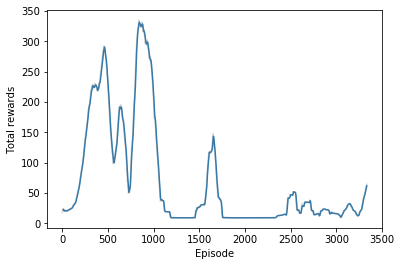

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

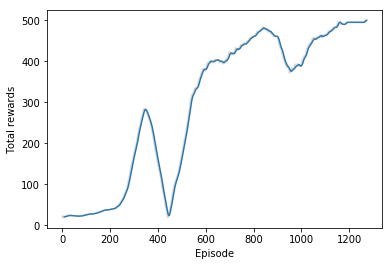

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

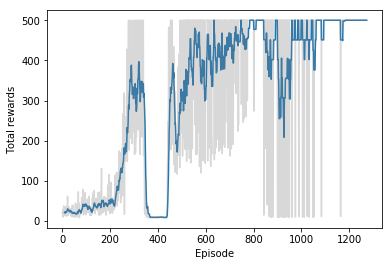

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [18]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 200.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 11.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.